# Downloading repositories and data

In [ ]:
!git clone https://github.com/mskv99/Defect-Detection.git

Cloning into 'Defect-Detection'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 327 (delta 130), reused 184 (delta 95), pack-reused 98
Receiving objects: 100% (327/327), 207.80 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (156/156), done.


Cloned repository has the following structure:

```
├── Defect-Detection
│   ├── Defects_FasterRCNN.ipynb
│   ├── Defects_RetinaNet.ipynb
│   ├── Defects_YOLOv5.ipynb
│   ├── NetDirectory
│   │   ├── config.py
│   │   ├── custom_utils.py
│   │   ├── datasets.py
│   │   ├── eval.py
│   │   ├── inference.py
│   │   ├── models
│   │   └── train.py
│   ├── README.md
│   └── RT_DETR.ipynb
```


`'.ipynb'` files represent jupyter notebooks for particualar object detection model. Now you are working with one of these models - RetinaNet. `NetDirectory` folder contatins auxilary `'.py'` files.

Enter the `NetDirectory` folder. Open the `config.py` and define your seeting for training/evaluating the model.

In [ ]:
%cd /content/Defect-Detection/NetDirectory/
!pwd

/content/Defect-Detection/NetDirectory
/content/Defect-Detection/NetDirectory


In [ ]:
#download last version of dataset

!curl -L 'https://app.roboflow.com/ds/WY3Kia0nPR?key=FhUQWiFiXI' > roboflow.zip; unzip roboflow.zip -d custom_data;rm roboflow.zip

In [ ]:
!pip install wandb


In [ ]:
!pip install torchmetrics


In [ ]:
!pip install torchinfo

In [ ]:
!wandb login
#7f7117ef2660f827c823ba03863048fe0eea4801

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="RetinaNet",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "resnet50_fpnv2",
    "dataset": "Defect_dataset_v6",
    "epochs": 40,
    "optimizer" : 'Adam',
    'batch_size':'10',
    'augmentations': 'blur_augmentations',
    'scheduler': 'step_lr_10_ep_gamma_0.1',
    }
)

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
import glob as glob
from google.colab.patches import cv2_imshow
from torch.utils.tensorboard import SummaryWriter

from xml.etree import ElementTree as et
import random
from torch.utils.data import Dataset, DataLoader

from custom_utils import (
    SaveBestModel,
    save_model,
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import matplotlib.pyplot as plt
import time
import os
import pandas as pd




def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

Import modules from `NetDirectory`.

**`test_inference`** function allows you to make predictions on your test set. It creates `inference_outputs/images` directory and saves predictions within this directory. The reqired arugements:

*   DIR_TEST - path to your test images
*   CLASSES - LIST of classes you defined in `config.py`
*   model - your trained model
*   CONF_THRESHOLD - threshold to filter out bounding boxes with low confidence score. By default goes 0.5


**`per_class_stat`** function allows you to evalaute your model on validation or test set and get the per class Precision, Recall, mAP metrics under the defined IoU threshold level. Function saves the results to '.csv' file.The required arguments:
* valid_loader - there can be validation or test data loader instance
* model - traiend model
* classes - LIST of classes you defined in `config.py`
* save_path - provied the path with the name of '.csv' file where you want to save your metrics
* metric - create a metric object via `MeanAveragePrecision` class and provide this metric as an argument to command. For more details read [https://torchmetrics.readthedocs.io/en/v0.8.2/detection/mean_average_precision.html](https://)

**`validate`** function is used in training process to evaluate your model during training process and in the `per_class_stat` function. The required arguments:
* valid_data_loader - validation data loader instance
* model - model instance. Either one that is being trained or already trained depending on your purposes.
* metric - metric object.


In [ ]:
from inference import test_inference, per_class_stat
from eval import validate

# Creating dataset class and applying transforms


In [ ]:
from datasets import CustomDataset, plot_box, show_tranformed_image
from config import (BATCH_SIZE, RESIZE_TO, NUM_WORKERS,
                    NUM_EPOCHS, LEARNING_RATE, DEVICE,
                    TRAIN_DIR, VALID_DIR, TEST_DIR, CLASSES,
                    NUM_CLASSES, OUT_DIR, COLORS, STEP
                    )

dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO,CLASSES, transforms = None
)
print(f"Number of training images: {len(dataset)}")

Number of training images: 380


In [ ]:
OUT_DIR

'/content/Defect-Detection/NetDirectory/outputs'

In [ ]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.ToGray(p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


In [ ]:
# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size = B_SIZE,
        shuffle=True,
        num_workers = num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0, B_SIZE = BATCH_SIZE):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size = B_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader


# sanity check of the Dataset pipeline with sample visualization
dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO,CLASSES, transforms = None
)
print(f"Number of training images: {len(dataset)}")


Number of training images: 380


In [ ]:
# Function to plot images with the bounding boxes.
def plot(random_list):

    plt.figure(figsize=(8, 8))

    for idx, img in enumerate(random_list):
      image, target = dataset[img]
      result_image = plot_box(image, target)
      plt.subplot(2, 2, idx+1)
      plt.imshow(result_image.astype('uint8'))
      plt.axis('off')
    plt.tight_layout()
    plt.show()

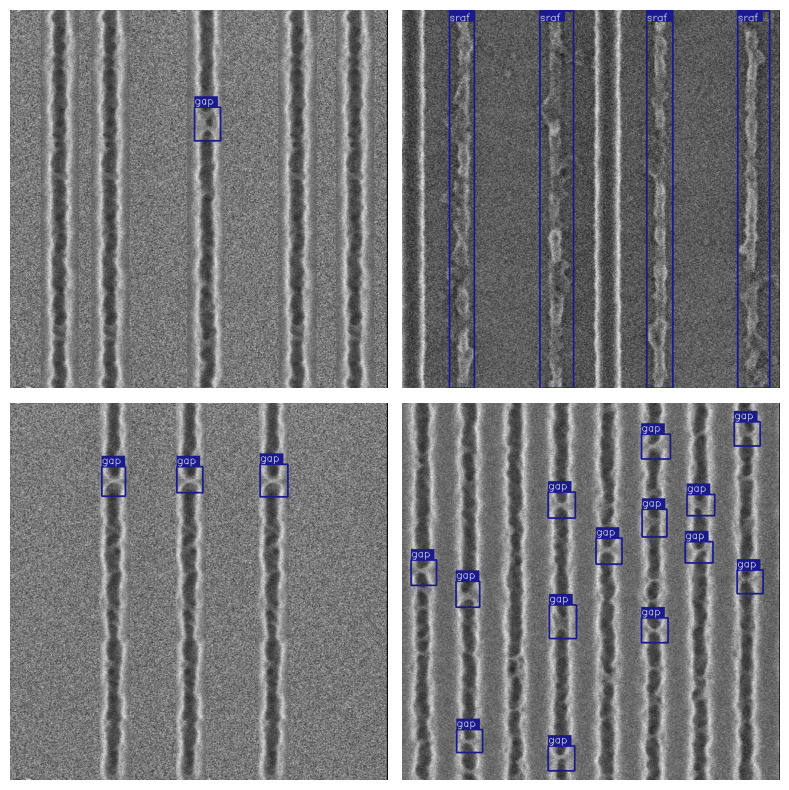

In [ ]:
random_numb = random.sample(range(0,len(dataset)), 4)
plot(random_numb)

In [ ]:
train_dataset = create_train_dataset(TRAIN_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)

valid_dataset = create_valid_dataset(VALID_DIR)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)

test_dataset = create_valid_dataset(TEST_DIR)
test_loader = create_valid_loader(test_dataset, NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 380
Number of validation samples: 83
Number of test samples: 37


In [ ]:
show_tranformed_image(train_loader, DEVICE, CLASSES, COLORS)

# Creating a model and defining optimizer


`NetDirectory` folder has the following structure:


```
├── config.py
├── custom_utils.py
├── datasets.py
├── eval.py
├── inference.py
├── models
│   ├── faster_rcnn
│   │   ├── create_fasterrcnn_model.py
│   │   ├── fasterrcnn_convnext_small.py
│   │   ├── fasterrcnn_convnext_tiny.py
│   │   ├── fasterrcnn_custom_resnet.py
│   │   ├── fasterrcnn_darknet.py
.....
│   │   ├── fasterrcnn_resnet152.py
│   │   ├── fasterrcnn_resnet18.py
│   │   ├── fasterrcnn_resnet50_fpn.py
│   │   ├── fasterrcnn_resnet50_fpn_v2.py
│   │   ├── fasterrcnn_squeezenet1_0.py
....
│   │   ├── layers.py
│   │   ├── model_summary.py
│   │   └── utils.py
│   └── retina_net
│       ├── resnet50_fpn_v2.py
│       └── retina_resnet101.py
└── train.py
```


In the code below you can choose any wanted backbone for faster r-cnn model. For that you shoud:
1. import module.
2. import function `create_model` from the imported module

In this case we work with **ResNet50-FPN-v2** backbone.

In [ ]:
import sys
sys.path.append('/content/Defect-Detection/NetDirectory/models/retina_net')

import resnet50_fpn_v2
from resnet50_fpn_v2 import create_model

In [ ]:
#createting fasterrcnn model
model = create_model(num_classes = NUM_CLASSES, pretrained = True)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = LEARNING_RATE, momentum=0.9, nesterov=True)
#optimizer = torch.optim.Adam(params, lr=0.00001, weight_decay=0.0005)
scheduler = StepLR(
    optimizer=optimizer, step_size = STEP, gamma=0.1, verbose=True
)

In [ ]:
from torchinfo import summary

summary(model, input_size = (1,3,640,640))

# Training and validation

In [ ]:
# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value


        losses.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return cumm_loss / len(train_data_loader)



In [ ]:
os.makedirs('outputs', exist_ok=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")


In [ ]:
# To store training loss and mAP values.
train_loss_list = []
#val_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
SAVE_PATH = '/content/Defect-Detection/NetDirectory/outputs/best_model.pth'


# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision(class_metrics=True)

# Training loop.
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    #train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss:.3f}")

    print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    wandb.log({'epoch': epoch,
               'train_loss': round(train_loss, 2),
               'map_50': metric_summary['map_50'],
               'map': metric_summary['map']}
      )

    wandb.watch(model, log='gradients')


    # save the best model till now.
    save_best_model(
        model, float(metric_summary['map']), epoch, 'outputs'
    )
    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)
    scheduler.step()

model_artifact = wandb.Artifact('FasterRCNN', type = 'model',
                            description = 'RetinaNet model with resnet50_fpn backbone; blur augmentations'
                            )
model_artifact.add_file(SAVE_PATH)

wandb.log_artifact(model_artifact)

In [ ]:
map_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/map.png')
loss_img = cv2.imread('/content/Defect-Detection/NetDirectory/outputs/train_loss.png')
cv2_imshow(map_img)
cv2_imshow(loss_img)

# Evaluating the model


In [ ]:
#checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model_path = '/content/Defect-Detection/NetDirectory/outputs/best_model.pth'
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")


Validating


  0%|          | 0/8 [00:00<?, ?it/s]

mAP_50: 93.232
mAP_50_95: 57.970


In [ ]:
VALID_RES_PATH = '/content/val_data.csv'

metric = MeanAveragePrecision(class_metrics=True, iou_thresholds = [0.5])
per_class_stat(valid_loader, model, CLASSES, VALID_RES_PATH, metric)

In [ ]:
TEST_RES_PATH = '/content/test_data.csv'
per_class_stat(test_loader, model, CLASSES, TEST_RES_PATH, metric)

If you want to log '.csv' tables  with AP/AR metrics to WandB server run two cells below and then finish run.

In [ ]:
metric_val_artifact = wandb.Artifact('Valid_metric', type = 'metric',
                            description = 'FasterRCNN valid metric with mAP50'
                            )
metric_val_artifact.add_file(VALID_RES_PATH)

wandb.log_artifact(metric_val_artifact)

In [ ]:
metric_test_artifact = wandb.Artifact('Test_metric', type = 'metric',
                            description = 'FasterRCNN test metric with mAP50'
                            )
metric_test_artifact.add_file(TEST_RES_PATH)

wandb.log_artifact(metric_test_artifact)

In [ ]:
wandb.finish()

Run the cell below if you want to save your model to google drive. Previously rename the model name:

 **best.pth**  ->  **your_model_name.pth**

 In our case:

 **best.pth** -> **faster_rcnn_resnet50_fpnv2.pth**

In [ ]:
%cp /content/Defect-Detection/NetDirectory/outputs/retinanet_resnet50_fpnv2.pth /content/drive/MyDrive/models

# Model inference on test data


In [ ]:
test_inference(TEST_DIR,CLASSES, model)

Run the cell below if you want to copy inference outputs to google drive. Previosuly rename the image directory.

In [ ]:
%cp -r /content/Defect-Detection/NetDirectory/inference_outputs/retinanet_resnet50\
      /content/drive/MyDrive/inference_outputs/retinanet_resnet50

# Loading trained model from Weights and Biases


In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('ml_team_mskv/RetinaNet/Retina:v9', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: andrew_mskv (ml_team_mskv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Retina:v9, 415.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.5


In [ ]:
from eval import validate
checkpoint = torch.load('/content/Defect-Detection/NetDirectory/artifacts/Retina:v9/best_model.pth', map_location=DEVICE)

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model, metric)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

In [ ]:
from inference import per_class_stat
SAVE_RES_PATH = '/content/data.csv'

per_class_stat(valid_loader, model, CLASSES, SAVE_RES_PATH, metric)

In [ ]:
run.finish()

# Load model from google drive


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/models/faster_rcnn_resnet50_fpnv2.pth', map_location=DEVICE)
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

metric = MeanAveragePrecision(class_metrics=True)
metric_summary = validate(valid_loader, model, metric)

print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

# Tuning hyperparameters

In [ ]:
import wandb

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'train_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'batch_size' : {
            'values' : [2,3,4]
            },

        'optimizer' : {
            'values' : ['SGD','Adam']
        },
        'learning_rate': {'distribution': 'uniform',
                          'max': 0.01,
                          'min': 0.00001},
        'epochs' : {'value': 5}
    },
    'description' : 'tuning hyperparameters for second dataset for resnet101 backbone'
}




In [ ]:
import pprint

pprint.pprint(sweep_config)
os.makedirs('outputs', exist_ok=True)

{'description': 'tuning hyperparameters for second dataset for resnet101 '
                'backbone',
 'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'train_loss'},
 'parameters': {'batch_size': {'values': [2, 3, 4]},
                'epochs': {'value': 5},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.01,
                                  'min': 1e-05},
                'optimizer': {'values': ['SGD', 'Adam']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'RetinaNet')

Create sweep with ID: 5q0l11mt
Sweep URL: https://wandb.ai/ml_team_mskv/RetinaNet/sweeps/5q0l11mt


In [ ]:
def train(train_data_loader, model, optimizer):
    print('Training')
    model.train()


     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    cumm_loss = 0

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        cumm_loss += loss_value

        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return cumm_loss/len(train_data_loader)

In [ ]:
def tune_param(config=None):
  #global train_loss_hist
  wandb.init(project = 'RetinaNet', config = config)
  config = wandb.config
  train_dataset = create_train_dataset(TRAIN_DIR)
  train_loader = create_train_loader(train_dataset, num_workers = 2, B_SIZE = config.batch_size)

  #model = create_model(num_classes = NUM_CLASSES)
  model = create_model(num_classes = NUM_CLASSES)
  model = model.to(DEVICE)
  params = [p for p in model.parameters() if p.requires_grad]

  # optimizer = torch.optim.SGD(params, lr=config.learning_rate)
  # print(optimizer)

  if config.optimizer == 'SGD':
    optimizer = torch.optim.SGD(params, lr = config.learning_rate, momentum = 0.9)
  elif config.optimizer == 'Adam':
    optimizer = torch.optim.Adam(params, lr = config.learning_rate)
  wandb.watch(model, log= 'all')


  for epoch in range(config.epochs):
      print(f"\nEPOCH {epoch+1} of {config.epochs}")

      # Reset the training loss histories for the current epoch.
      #train_loss_hist.reset()

      # Start timer and carry out training and validation.
      start = time.time()
      train_loss_epoch = train(train_loader, model, optimizer = optimizer)
      print(f"Epoch #{epoch+1} train loss: {train_loss_epoch:.3f}")

      end = time.time()
      print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


      wandb.log({'epoch': epoch,
                'train_loss': round(train_loss_epoch, 2)
                })

  wandb.finish()

In [ ]:
wandb.agent(sweep_id, function = tune_param, count = 10)

In [ ]:
#in case the tuning work corrupts or you want to resume the sweep
#just provide the sweep_id which includes user name, project name and id
#then launch wandb agent with corresponding sweep_id
sweep_id = 'ml_team_mskv/RetinaNet/1yth9rbd'
wandb.agent(sweep_id, function = tune_param, count = 5)